In [57]:
source('../NMEG_utils/r_functions/load_nmeg.r')
source('~/current/NMEG_utils/r_functions/printfigs.r')
require('xts')
require('forecast')
require('tseries')
require('astsa')
require('ggplot2')
require('reshape2')

In [58]:
# Get data and convert some variables to weekly frequency
site <- 'Vcm'
flux <- daily_to_xts(get_daily_file(site, 'aflx', make_new=FALSE))

# If data needs to be removed...(should be Wjs only)
sum(is.na(flux$P_F_sum))
#flux <- flux[124:nrow(flux)]
head(flux)

# convert to weekly values
p <- apply.weekly(flux$P_F_sum, sum)
ta <- apply.weekly(flux$TA_F_avg, mean)
nee <- apply.weekly(flux$FC_F_g_int, sum)
gpp <- apply.weekly(flux$GPP_g_int, sum)
re <- apply.weekly(flux$RECO_g_int, sum)

[1] 0

            GPP_g_int RECO_g_int FC_F_g_int ET_mm_24hint_0 P_F_sum   TA_F_avg
2007-01-01 0.12626547  0.2057688 0.07950336      1.0078243       0 -2.8387670
2007-01-02 0.09631599  0.4388484 0.34253244      0.9446642       0 -1.4170800
2007-01-03 0.22328216  0.3979440 0.17466182      0.7102144       0  0.8552379
2007-01-04 0.29392702  0.4046708 0.11074375      0.4587709       0  1.0826423
2007-01-05 0.19976371  0.2330954 0.03333168      0.4499571       0 -6.3807404
2007-01-06 0.05133946  0.4993724 0.44803295      1.7670479       0 -9.9878025
           RH_F_avg SW_IN_F_avg RNET_F_avg  VPD_F_avg PAR_avg LE_F_avg
2007-01-01 49.87072   113.84493         NA 0.25164502      NA 29.86326
2007-01-02 40.51016   129.52388         NA 0.33900065      NA 27.33408
2007-01-03 32.04234   144.08240         NA 0.44169131      NA 20.51855
2007-01-04 41.48273   147.71834         NA 0.39319227      NA 13.26052
2007-01-05 81.55373    24.10896         NA 0.07710852      NA 13.10221
2007-01-06 67.66120    73.07

## Test models for simulating GPP

### Smoothing models

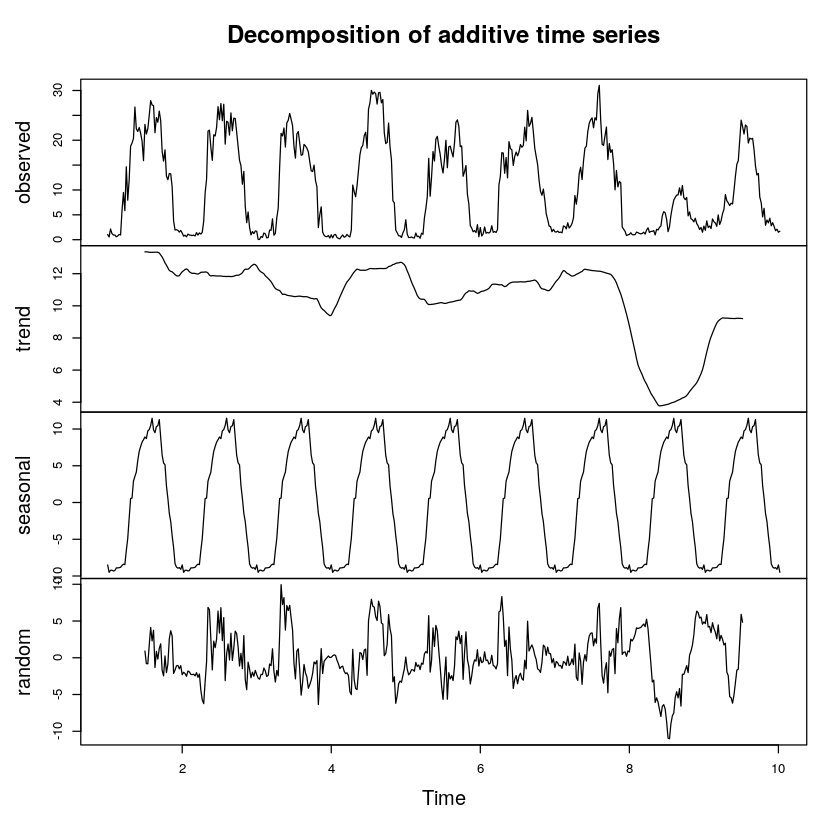

In [59]:
# Create a timeseries object and decompose it
#gpp_ts<-ts(gpp, frequency = 52, start = c(2008, 1, 6),end = c(2014, 12, 31))
attr(gpp, 'frequency') <- 52
gpp_decomp <- decompose(as.ts(gpp))

# Plot
decomp_plot1 <- plot(gpp_decomp)

# Add seasonal and seasonal + trend columns to gpp
gpp$decomp_seas <- xts(gpp_decomp$seasonal + mean(gpp, na.rm=TRUE), index(gpp))
gpp$decomp_seastrend <- xts(gpp_decomp$seasonal + gpp_decomp$trend, index(gpp))
#head(gpp)

pdf 
  2

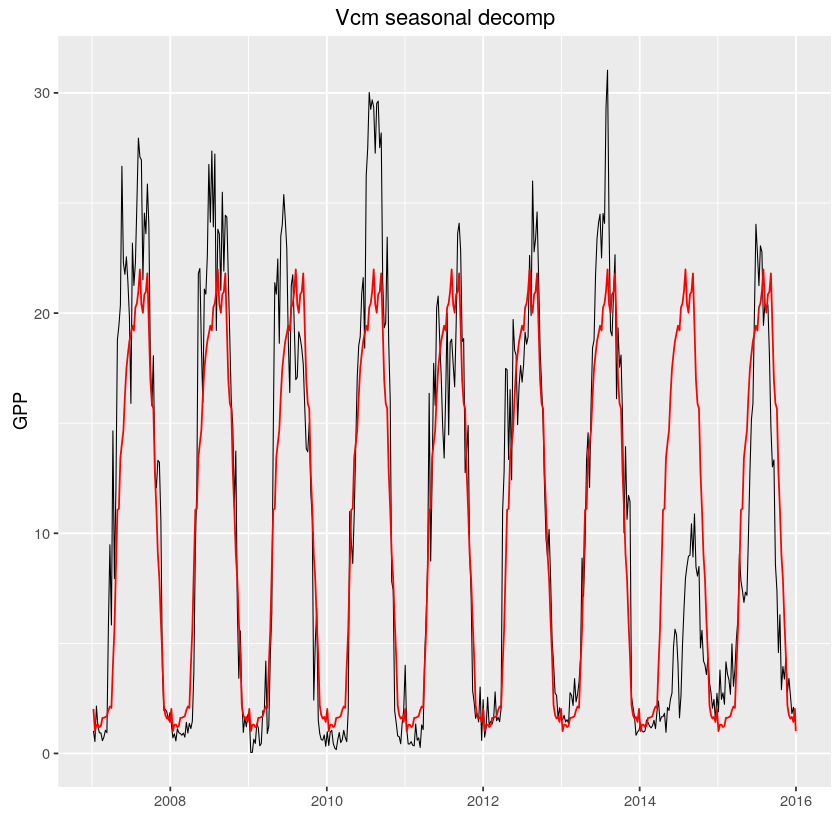

In [60]:
# Plot the seasonal mean
decomp_plot2 <- ggplot(gpp) + geom_line(aes(index(gpp), GPP_g_int), size=0.3) + 
    geom_line(aes(index(gpp), decomp_seas), color='red') + 
    xlab("") + ylab("GPP") + ggtitle(paste(site, 'seasonal decomp', sep=' '))
decomp_plot2
printfigs(decomp_plot2, paste(site, '_decomp_seas.svg', sep=''), 'figures/', 6, 2.5)

### Linear model with temp

pdf 
  2

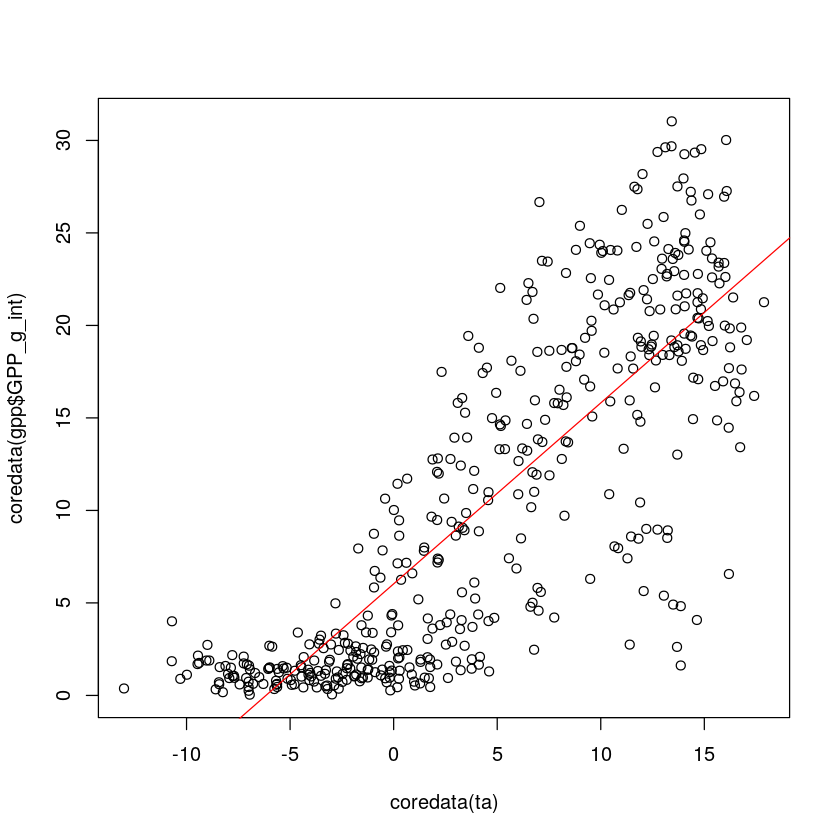

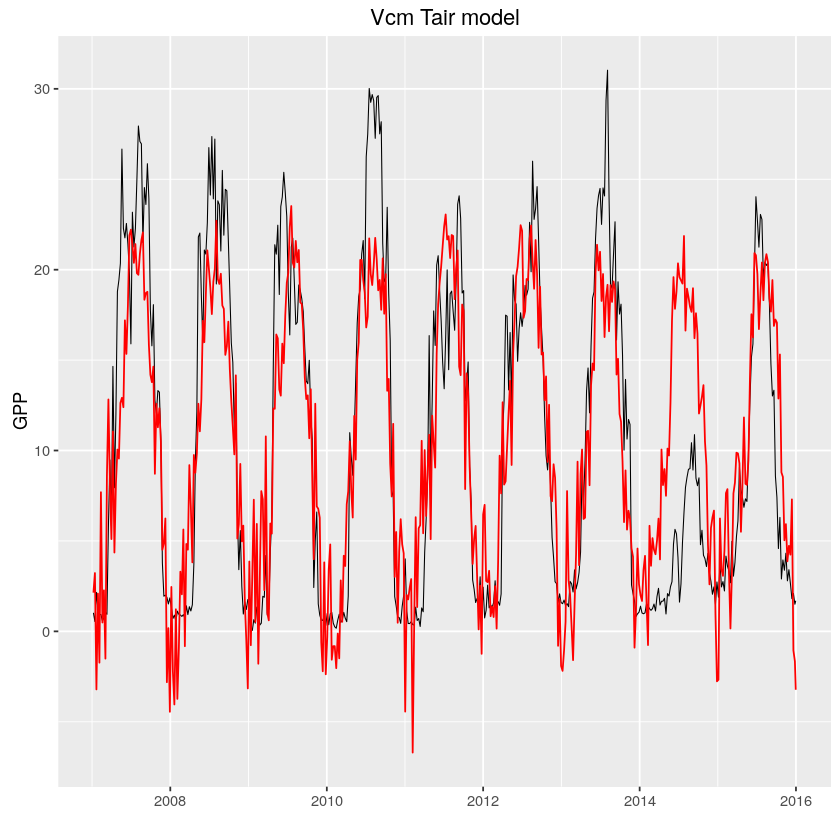

In [61]:
# First make a scatterplot
plot(coredata(ta), coredata(gpp$GPP_g_int))
# Fit model
fit_ta_lm <- lm(coredata(gpp$GPP_g_int) ~ coredata(ta))
gpp$fitted_ta_lm <- xts(fitted(fit_ta_lm), index(gpp))
abline(fit_ta_lm, col='red')

ta_plot <- ggplot(gpp) + geom_line(aes(index(gpp), GPP_g_int), size=0.3) + 
    geom_line(aes(index(gpp), fitted_ta_lm), color='red') + 
    xlab("") + ylab("GPP") + ggtitle(paste(site, 'Tair model', sep=' '))
printfigs(ta_plot, paste(site, '_ta_linmod.svg', sep=''), 'figures/', 6, 2.5)
ta_plot

### Linear model temp + precip

In [62]:
# rolling sum of precip?
p_3wk <- rollapply(p, 3, sum, fill=NA, align='right')
head(p_3wk)

           P_F_sum
2007-01-07      NA
2007-01-14      NA
2007-01-21  72.648
2007-01-28  72.648
2007-02-04  19.048
2007-02-11  31.498

Warning message:
: Removed 2 rows containing missing values (geom_path).

pdf 
  2

Warning message:
: Removed 2 rows containing missing values (geom_path).

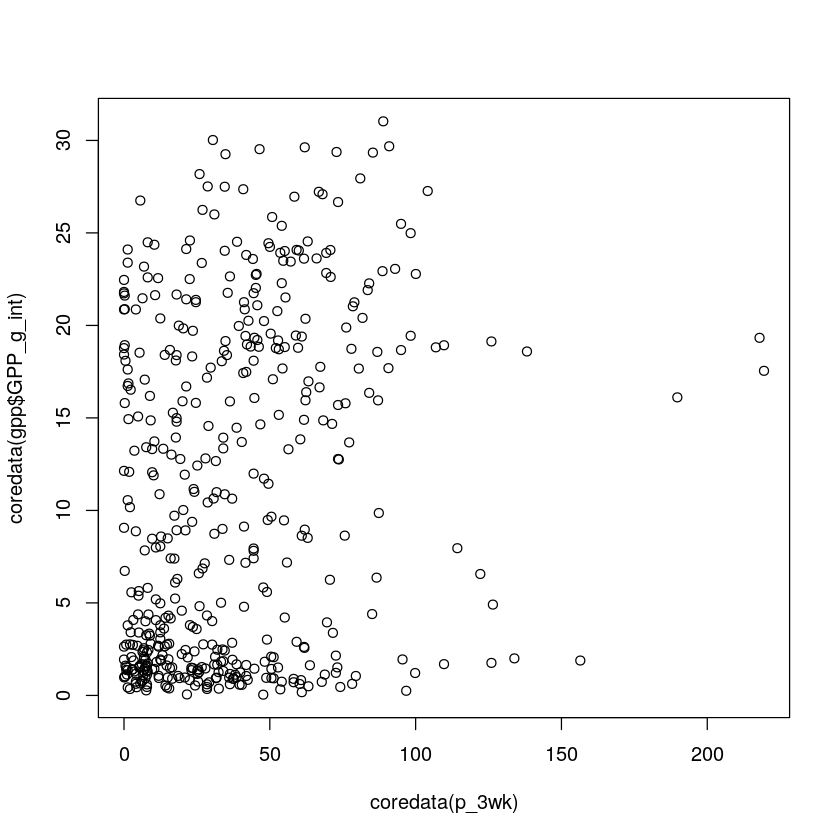

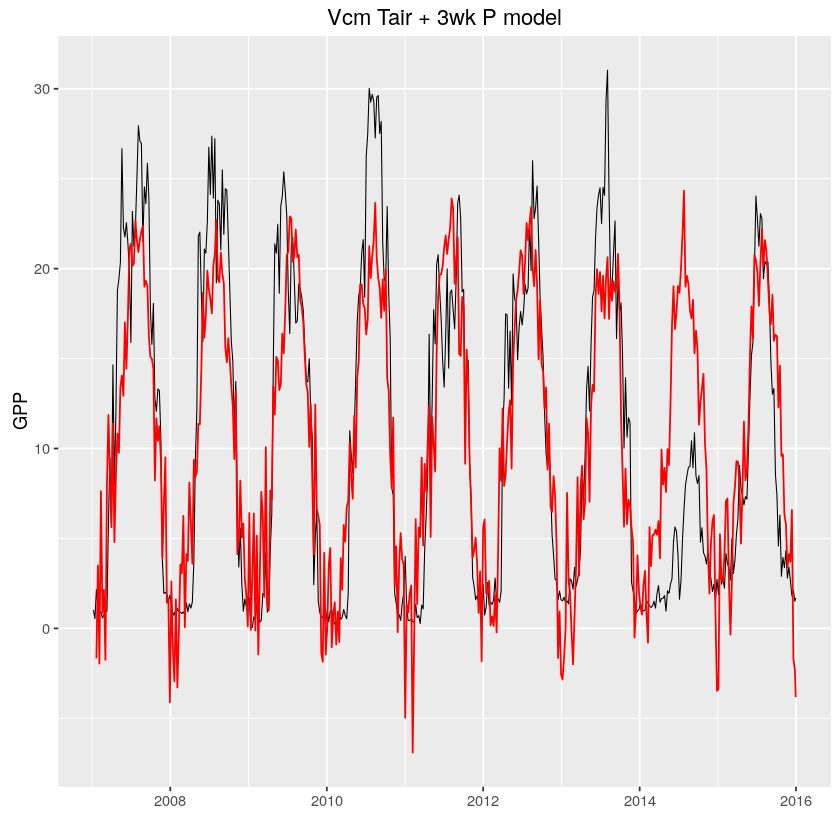

In [63]:
# First make a scatterplot
plot(coredata(p_3wk), coredata(gpp$GPP_g_int))
# Fit model
fit_taP_lm <- lm(coredata(gpp$GPP_g_int) ~ coredata(ta) + coredata(p_3wk), na.action='na.exclude')
gpp$fitted_taP_lm <- xts(fitted(fit_taP_lm), index(gpp))
#abline(fit_taP_lm, col='red')

taP_plot <- ggplot(gpp) + geom_line(aes(index(gpp), GPP_g_int), size=0.3) + 
    geom_line(aes(index(gpp), fitted_taP_lm), color='red') + 
    xlab("") + ylab("GPP") + ggtitle(paste(site, 'Tair + 3wk P model', sep=' '))
printfigs(taP_plot, paste(site, '_taP_linmod.svg', sep=''), 'figures/', 6, 2.5)
taP_plot

## Residual analysis

pdf 
  2

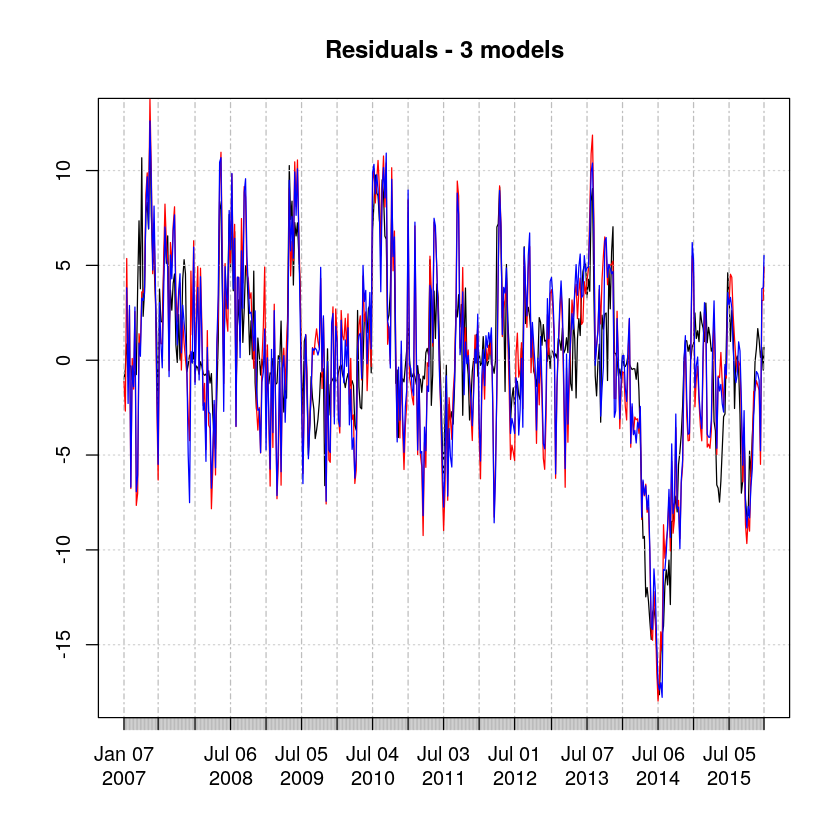

In [64]:
# Calculate the residuals for the models
gpp$resid_decompseas <- gpp$GPP_g_int - gpp$decomp_seas
gpp$resid_ta_lm <- gpp$GPP_g_int - gpp$fitted_ta_lm
gpp$resid_taP_lm <- gpp$GPP_g_int - gpp$fitted_taP_lm

# Plot residuals
p <- plot(gpp$resid_decompseas, main='Residuals - 3 models')
lines(gpp$resid_ta_lm, col='red')
lines(gpp$resid_taP_lm, col='blue')

printfigs(p, paste(site, '_ta_resid.svg', sep=''), 'figures/', 6, 3.5)

,resid_decompseas,resid_ta_lm,resid_taP_lm,idx
April,12.29518,-2.269755,-6.752961,2014-04-01
August,-0.2609704,41.63466,16.87288,2014-08-01
December,-1.178534,-7.880401,-15.41462,2014-12-01
February,-4.203891,-6.858139,-4.699941,2014-02-01
January,-0.9955226,-23.08616,NA,2014-01-01
July,1.46954,4.202443,-13.45051,2014-07-01


,idx,variable,value
1,2014-04-01,resid_decompseas,12.29518
2,2014-08-01,resid_decompseas,-0.2609704
3,2014-12-01,resid_decompseas,-1.178534
4,2014-02-01,resid_decompseas,-4.203891
5,2014-01-01,resid_decompseas,-0.9955226
6,2014-07-01,resid_decompseas,1.46954


pdf 
  2

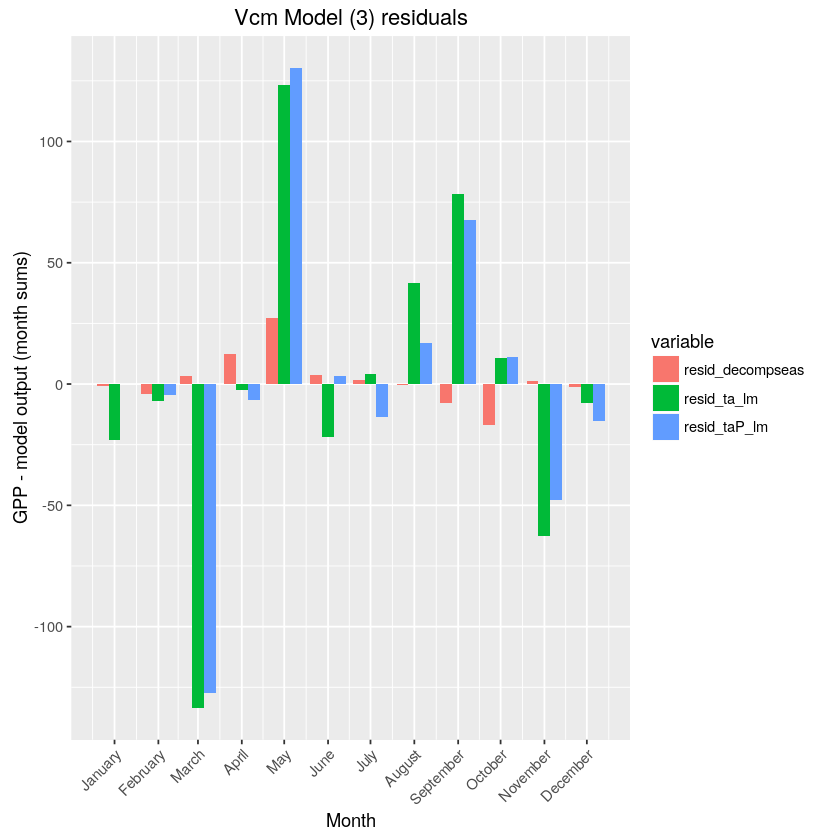

In [65]:
# Aggregate residual columns to monthly means and make dataframe
resid_nm <- grep('resid_', names(gpp))
agg_mon <- aggregate(gpp[,resid_nm], months(index(gpp)), sum)
# Get date index and convert to dataframe
idx <- as.Date(paste('1', index(agg_mon), '2014', sep='-'), '%d-%b-%Y')
agg_mon <- as.data.frame(agg_mon)
agg_mon$idx <- idx
# Melt along date index
head(agg_mon)
agg_mon <- melt(agg_mon, id='idx')
head(agg_mon)
# Plot
resid_monthly_plot <- ggplot(agg_mon) + 
    geom_bar(aes(x=idx, y=value, fill=variable), stat='identity', position='dodge') + 
    xlab("Month") + ylab("GPP - model output (month sums)") +
    scale_x_date(date_breaks = "1 month", date_labels = "%B") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    ggtitle(paste(site, 'Model (3) residuals', sep=' '))
resid_monthly_plot

printfigs(resid_monthly_plot, paste(site, '_modelresid_bars.svg', sep=''), 'figures/', 6, 3.5)